In [1]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d kmader/food41
! unzip food41.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/tacos/1026681.jpg  
  inflating: images/tacos/1030289.jpg  
  inflating: images/tacos/1033196.jpg  
  inflating: images/tacos/1036030.jpg  
  inflating: images/tacos/1042175.jpg  
  inflating: images/tacos/1044043.jpg  
  inflating: images/tacos/1058697.jpg  
  inflating: images/tacos/1059239.jpg  
  inflating: images/tacos/1059326.jpg  
  inflating: images/tacos/1066762.jpg  
  inflating: images/tacos/1070967.jpg  
  inflating: images/tacos/1073468.jpg  
  inflating: images/tacos/1075296.jpg  
  inflating: images/tacos/1085243.jpg  
  inflating: images/tacos/108529.jpg  
  inflating: images/tacos/1086014.jpg  
  inflating: images/tacos/108945.jpg  
  inflating: images/tacos/1089575.jpg  
  inflating: images/tacos/1091159.jpg  
  inflating: images/tacos/1101369.jpg  
  inflating: images/tacos/1109058.jpg  
  inflating: images/tacos/1109744.jpg  
  inflating: images/tacos/1119371.jpg  
  inflating: images/tacos/11237

Using device: cuda
Starting training...


 10%|█         | 100/1000 [01:23<11:38,  1.29it/s]

Episode 100/1000 - Loss: 22.5367, Accuracy: 31.19%


 20%|██        | 200/1000 [02:45<10:55,  1.22it/s]

Episode 200/1000 - Loss: 2.2402, Accuracy: 28.56%


 30%|███       | 300/1000 [04:04<08:57,  1.30it/s]

Episode 300/1000 - Loss: 1.6984, Accuracy: 30.29%


 40%|████      | 400/1000 [05:23<08:28,  1.18it/s]

Episode 400/1000 - Loss: 1.5853, Accuracy: 32.60%


 50%|█████     | 500/1000 [06:40<06:13,  1.34it/s]

Episode 500/1000 - Loss: 1.5504, Accuracy: 33.96%


 60%|██████    | 600/1000 [07:55<04:47,  1.39it/s]

Episode 600/1000 - Loss: 1.5129, Accuracy: 34.83%


 70%|███████   | 700/1000 [09:09<03:38,  1.37it/s]

Episode 700/1000 - Loss: 1.4987, Accuracy: 35.04%


 80%|████████  | 800/1000 [10:23<02:25,  1.37it/s]

Episode 800/1000 - Loss: 1.5003, Accuracy: 35.20%


 90%|█████████ | 900/1000 [11:37<01:12,  1.37it/s]

Episode 900/1000 - Loss: 1.4841, Accuracy: 36.40%


100%|██████████| 1000/1000 [12:50<00:00,  1.30it/s]


Episode 1000/1000 - Loss: 1.4745, Accuracy: 36.76%

Evaluating model...


100%|██████████| 100/100 [01:08<00:00,  1.46it/s]



Test Accuracy: 36.31% ± 8.64%

Generating embedding visualization...


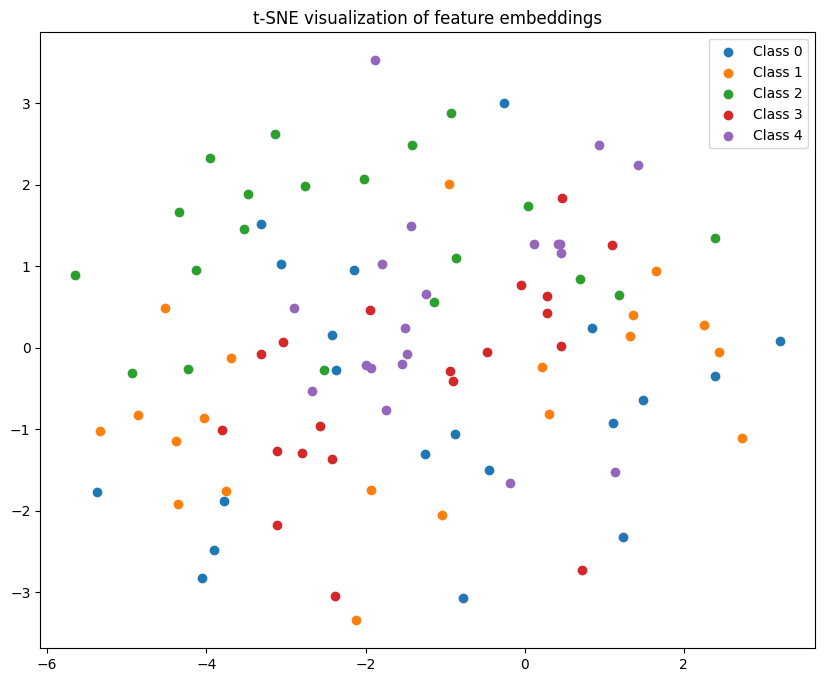

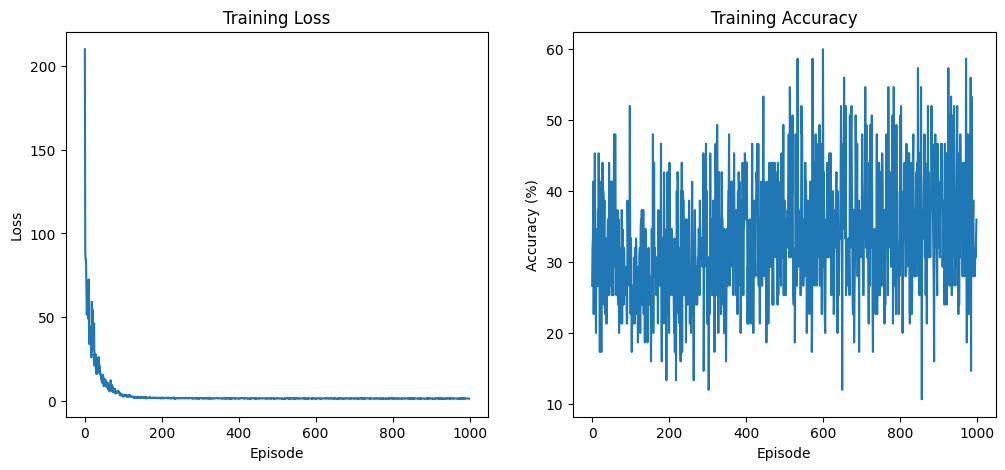

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

class ProtoNet(nn.Module):
    def __init__(self, in_channels=3, hidden_dim=64):
        super(ProtoNet, self).__init__()

        self.encoder = nn.Sequential(
            self._conv_block(in_channels, hidden_dim),
            self._conv_block(hidden_dim, hidden_dim),
            self._conv_block(hidden_dim, hidden_dim),
            self._conv_block(hidden_dim, hidden_dim)
        )

    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)

class EnhancedFewShotDataset(Dataset):
    def __init__(self, root_dir, transform=None, augment=True, device='cuda'):
        self.root_dir = root_dir
        self.transform = transform
        self.device = device
        self.augment = augment
        self.classes = os.listdir(root_dir)
        self.class_to_images = {
            cls: [os.path.join(root_dir, cls, img) for img in os.listdir(os.path.join(root_dir, cls))]
            for cls in self.classes
        }

        if augment:
            self.augmentation = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1))
            ])

    def get_episode(self, n_way, k_shot, k_query):
        selected_classes = random.sample(self.classes, n_way)
        support_imgs, query_imgs = [], []
        support_labels, query_labels = [], []

        for i, cls in enumerate(selected_classes):
            imgs = random.sample(self.class_to_images[cls], k_shot + k_query)

            # Support set
            for img_path in imgs[:k_shot]:
                img = self.load_and_transform_image(img_path, augment=self.augment)
                support_imgs.append(img)
                support_labels.append(i)

            # Query set
            for img_path in imgs[k_shot:]:
                img = self.load_and_transform_image(img_path, augment=False)
                query_imgs.append(img)
                query_labels.append(i)

        support_imgs = torch.stack(support_imgs).to(self.device)
        query_imgs = torch.stack(query_imgs).to(self.device)
        support_labels = torch.tensor(support_labels).to(self.device)
        query_labels = torch.tensor(query_labels).to(self.device)

        return support_imgs, support_labels, query_imgs, query_labels

    def load_and_transform_image(self, img_path, augment=False):
        image = Image.open(img_path).convert('RGB')
        if augment and self.augment:
            image = self.augmentation(image)
        if self.transform:
            image = self.transform(image)
        return image

def euclidean_distance(x, y):
    return torch.sum((x.unsqueeze(1) - y.unsqueeze(0)).pow(2), dim=2)

def prototype_loss(prototypes, query_features, query_labels, n_way):
    dists = euclidean_distance(query_features, prototypes)
    log_p_y = F.log_softmax(-dists, dim=1)
    loss = -log_p_y.gather(1, query_labels.unsqueeze(1)).squeeze().mean()
    return loss

def compute_prototypes(support_features, support_labels, n_way):
    prototypes = torch.zeros(n_way, support_features.size(1)).to(support_features.device)
    for i in range(n_way):
        mask = support_labels == i
        prototypes[i] = support_features[mask].mean(0)
    return prototypes

def train_proto(model, dataset, optimizer, n_episodes, n_way, k_shot, k_query, device):
    model.train()
    losses = []
    accuracies = []

    for episode in tqdm(range(n_episodes)):
        optimizer.zero_grad()

        # Get episode data
        support_imgs, support_labels, query_imgs, query_labels = dataset.get_episode(n_way, k_shot, k_query)

        # Extract features
        support_features = model(support_imgs)
        query_features = model(query_imgs)

        # Compute prototypes
        prototypes = compute_prototypes(support_features, support_labels, n_way)

        # Calculate loss and update model
        loss = prototype_loss(prototypes, query_features, query_labels, n_way)
        loss.backward()
        optimizer.step()

        # Compute accuracy
        dists = euclidean_distance(query_features, prototypes)
        pred = torch.argmin(dists, dim=1)
        acc = (pred == query_labels).float().mean().item() * 100

        losses.append(loss.item())
        accuracies.append(acc)

        if (episode + 1) % 100 == 0:
            avg_loss = np.mean(losses[-100:])
            avg_acc = np.mean(accuracies[-100:])
            print(f"Episode {episode + 1}/{n_episodes} - Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%")

    return losses, accuracies

def evaluate_proto(model, dataset, n_episodes, n_way, k_shot, k_query, device):
    model.eval()
    accuracies = []

    with torch.no_grad():
        for episode in tqdm(range(n_episodes)):
            support_imgs, support_labels, query_imgs, query_labels = dataset.get_episode(n_way, k_shot, k_query)

            # Extract features
            support_features = model(support_imgs)
            query_features = model(query_imgs)

            # Compute prototypes
            prototypes = compute_prototypes(support_features, support_labels, n_way)

            # Compute accuracy
            dists = euclidean_distance(query_features, prototypes)
            pred = torch.argmin(dists, dim=1)
            acc = (pred == query_labels).float().mean().item() * 100
            accuracies.append(acc)

    return np.mean(accuracies), np.std(accuracies)

def visualize_embeddings(model, dataset, n_way, k_shot, k_query, device):
    model.eval()

    with torch.no_grad():
        support_imgs, support_labels, query_imgs, query_labels = dataset.get_episode(n_way, k_shot, k_query)

        # Get embeddings
        support_features = model(support_imgs).cpu().numpy()
        query_features = model(query_imgs).cpu().numpy()

        # Combine features and labels
        all_features = np.vstack([support_features, query_features])
        all_labels = np.concatenate([support_labels.cpu().numpy(), query_labels.cpu().numpy()])

        # Reduce dimensionality for visualization
        tsne = TSNE(n_components=2, random_state=42)
        embedded_features = tsne.fit_transform(all_features)

        # Plot
        plt.figure(figsize=(10, 8))
        for i in range(n_way):
            mask = all_labels == i
            plt.scatter(embedded_features[mask, 0], embedded_features[mask, 1], label=f'Class {i}')
        plt.legend()
        plt.title('t-SNE visualization of feature embeddings')
        plt.show()

if __name__ == "__main__":
    # Set random seeds for reproducibility
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Dataset setup
    transform = transforms.Compose([
        transforms.Resize((84, 84)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    data_path = "/content/images"  # Update this path
    dataset = EnhancedFewShotDataset(data_path, transform=transform, device=device)

    # Model setup
    model = ProtoNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training parameters
    n_episodes = 1000
    n_way = 5
    k_shot = 5
    k_query = 15

    # Training
    print("Starting training...")
    train_losses, train_accuracies = train_proto(
        model, dataset, optimizer, n_episodes, n_way, k_shot, k_query, device
    )

    # Evaluation
    print("\nEvaluating model...")
    mean_accuracy, std_accuracy = evaluate_proto(
        model, dataset, 100, n_way, k_shot, k_query, device
    )
    print(f"\nTest Accuracy: {mean_accuracy:.2f}% ± {std_accuracy:.2f}%")

    # Visualize embeddings
    print("\nGenerating embedding visualization...")
    visualize_embeddings(model, dataset, n_way, k_shot, k_query, device)

    # Plot training curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Episode')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies)
    plt.title('Training Accuracy')
    plt.xlabel('Episode')
    plt.ylabel('Accuracy (%)')
    plt.show()

    # Save model
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
    }, 'proto_net_model.pth')